In [4]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,classification

from yellowbrick.text import FreqDistVisualizer
from nltk.corpus import stopwords
import requests
import time
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re


In [8]:
def get_reddit_posts(subreddit, pages):
    url = "https://www.reddit.com/r/" + subreddit + ".json"
    headers = {'User-agent':'Time Bandit'}
    after = None
    posts = []
    for j in range(pages):
        if after==None:
            params = {}
        else:
            params = {'after':after}
        print(j)  # just to keep track of progress while it is running
        res = requests.get(url,params=params, headers=headers)
        if res.status_code==200:
            the_json = res.json()
            for i in range(len(the_json['data']['children'])):
                posts.append({'subreddit': the_json['data']['children'][i]['data']['subreddit'],
                                  'name':the_json['data']['children'][i]['data']['name'],
                                  'title':the_json['data']['children'][i]['data']['title'],
                              'text':the_json['data']['children'][i]['data']['selftext'],
                              'url':the_json['data']['children'][i]['data']['url'],
                                 'is_self': the_json['data']['children'][i]['data']['is_self']})
            after = the_json['data']['after']
        else:
            print(res.status_code)
            break
        time.sleep(1)
    return pd.DataFrame(posts)    

In [10]:
df=get_reddit_posts('AskHistorians',40)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [11]:
df.to_pickle('askhistorians.pkl')

In [13]:
df_science = pd.read_pickle('./science.pkl')

In [14]:
df = pd.concat([df, df_science])
df = df.reset_index(drop=True)
df.subreddit.value_counts()

askscience       1001
AskHistorians     997
Name: subreddit, dtype: int64

In [15]:
df['is_self'].value_counts()

True     1997
False       1
Name: is_self, dtype: int64

In [7]:
# remove cases with blank text
# df = df[df['text']!='']

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df.shape

(1998, 6)

In [18]:
# calculate baseline
df.subreddit.value_counts(normalize=True)

askscience       0.501001
AskHistorians    0.498999
Name: subreddit, dtype: float64

In [19]:
df['text'] = df['text'] +' '+ df['title']

In [20]:
# Data Cleaning
# Binarize label column
df['science'] = df['subreddit'].apply(lambda x: 1 if x == 'askscience' else 0)

# get rid of \n,  and &amp in text
df['text'] = df['text'].map(lambda x: x.replace('\n',' '))

df['text'] = df['text'].map(lambda x: x.replace('&amp;','and'))

In [21]:
# Load stopwords from NLTK and add custom words
mystopwords = stopwords.words('english')
mystopwords.extend(['like','would','get','x200b','https','one','www','com','org','etc','could'])

In [22]:
X = df['text']  # X will be turned into a matrix
y = df['science']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [36]:
# Logistic Regression model with Count Vectorizer
cvec = CountVectorizer(stop_words=mystopwords,max_features=None, ngram_range=(1,1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

lr = LogisticRegression(penalty='l2',solver='liblinear',C=.001)

lr.fit(X_train_cvec, y_train)

print('Logistic Regression model with Count Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_cvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_cvec, y_test):.3f}')

Logistic Regression model with Count Vectorizer
Train score: 0.949
Test score: 0.886


In [37]:
# set up X, y for Naive Bayes and SVC Models
X = df[['text']]  # X is a pd Dataframe
y = df['science']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [70]:
cvec = CountVectorizer(stop_words=None,max_features=None,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.005)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Bernoulli model with Count Vectorizer
Train data accuracy: 0.991
Test data accuracy: 0.922


In [79]:
cvec = CountVectorizer(stop_words=None,max_features=4000,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.7)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Multinomial model with Count Vectorizer
Train data accuracy: 0.988
Test data accuracy: 0.952


In [80]:
# print confusion matrix
y_pred = nb.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['predict neg', 'predict pos'], index=['actual neg', 'actual pos'])
cm_df

,predict neg,predict pos
actual neg,235,14
actual pos,10,241


In [81]:
# add predicted and actual y to test dataset
X_test['y_test'] = pd.Series(y_test, index=X_test.index)
X_test['y_pred'] = pd.Series(y_pred, index=X_test.index)

import re
# count words in text
X_test['word_count'] = pd.Series([len(re.findall(r'\w+', x)) for x in X_test.text], index=X_test.index)

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [82]:
# list false positives - predicted Science but actually History
mask = (X_test['y_test']==0) & (X_test['y_pred'] ==1)
X_test[mask]

,text,y_test,y_pred,word_count
877,"With no detailed map, no reliable magnetic fie...",0,1,40
775,I've been studying to become an insurance agen...,0,1,59
308,I read that the trireme warship’s ram was desi...,0,1,36
258,I walk into a Saloon or similar establishment...,0,1,29
724,"I mean, it seems to me that other (cartridge) ...",0,1,43
1,[Previous weeks!](/r/AskHistorians/search?sort...,0,1,289
934,(Sorry if this is the wrong subreddit to post ...,0,1,42
726,Weird question ik. But would the people in cha...,0,1,42
58,"To explain, it wasn't that long ago that human...",0,1,50
843,How large would Viking raiding parties be?,0,1,7


In [130]:
X_test.text.loc[252]

' Is there any chance we discover evidence of a civilization older than any we currently know? Or are we fairly sure that the mespotamian civilization was the first?'

In [83]:
X_test['word_count'].mean()

63.54

In [84]:
X_test['word_count'][mask].mean()

56.214285714285715

In [85]:
# list false negatives
mask = (X_test['y_test']==1) & (X_test['y_pred'] ==0)
X_test[mask]

,text,y_test,y_pred,word_count
1227,Noticed a news report today about a state of e...,1,0,130
1114,And do people in the different types of coma h...,1,0,67
1065,Just a shower thought I had when I was review...,1,0,81
1325,"A geologist was quoted by the BBC as saying ""...",1,0,52
1618,How does a Portuguese Man O' War reproduce if...,1,0,16
1759,"Herodotus reports (I,80) that Cyrus used camel...",1,0,43
1968,How are modern processor architectures tested...,1,0,8
1967,So I got into this story in a thread and I'm w...,1,0,212
1359,How did people wash themselves and clean thei...,1,0,16
1293,How did where the land meets the sea in Irela...,1,0,19


In [118]:
X_test.text.loc[1967]

"So I got into this story in a thread and I'm wondering if my childhood in the scenario was normal and scientifically sound/following doctors advice of the time. I was born in 1990. And I got the chicken pox sometime after 94 I know the vaccine now came to the US in 95 but I assume it wasnt out yet but idk maybe it was and wasnt popular? I say this because I remember having chicken pox and I dont remember being 5. But anyway my parents told my parents friends I had chicken pox and their parents decided let's have a play date and sleep over to give our kids chicken pox so they get it to. The idea was to get the disease so you were immune to it for later and I guess maybe shingles? Because maybe the younger you are the less harmful? Idk anyway the only time I started thinking this was weird was when the anti vax thing became popular and I was like wait... there is a chicken pox vaccine? And told my story. So was this the norm or was this weird? What was the protocol for chicken pox and s

In [87]:
X_test['word_count'][mask].mean()

64.4

In [65]:
tvec = TfidfVectorizer(stop_words=None,max_features=4000,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.3)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Multinomial model with TF-IDF Vectorizer
Train data accuracy: 0.994
Test data accuracy: 0.944


In [56]:
tvec = TfidfVectorizer(stop_words=None,max_features=4000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.003)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Bernoulli model with TF-IDF Vectorizer
Train data accuracy: 0.981
Test data accuracy: 0.922


In [104]:
# SVM model
cvec = CountVectorizer(stop_words=mystopwords,max_features=800, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())
# Instantiate SVM.
# svc = svm.SVC(kernel='poly', C = 1.8, gamma = .05) 
svc = svm.SVC(kernel='rbf', C = 15, gamma = .001)  

# Fit on training data.
svc.fit(X_train_cvec,y_train)

# Score model on the training set.
print('Support Vector Machine model with Count Vectorizer')
print(f'Train data accuracy: {svc.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {svc.score(X_test_cvec,y_test):.3f}')

Support Vector Machine model with Count Vectorizer
Train data accuracy: 0.909
Test data accuracy: 0.820


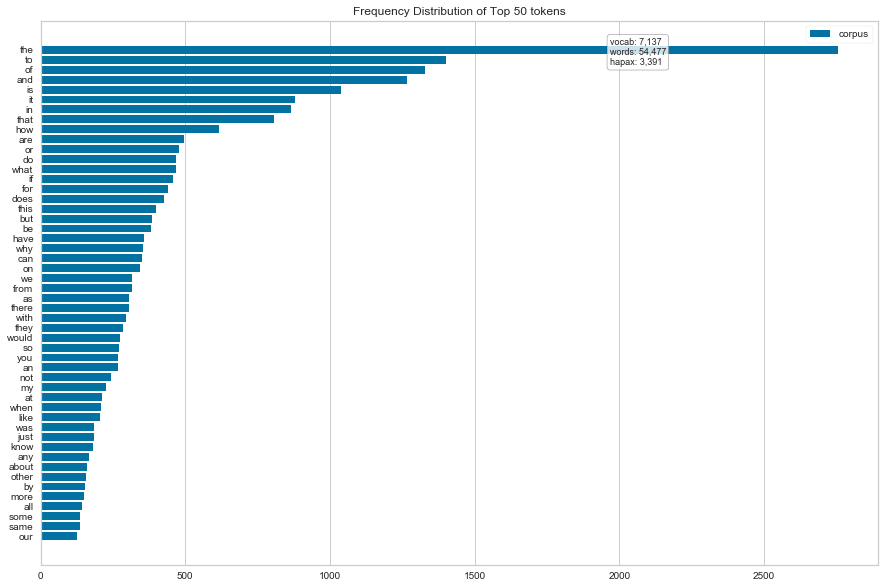

In [88]:
# https://www.scikit-yb.org/en/latest/api/text/freqdist.html
mask       = (df['science'] == 1)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50,)
visualizer.fit(docs)
visualizer.poof()

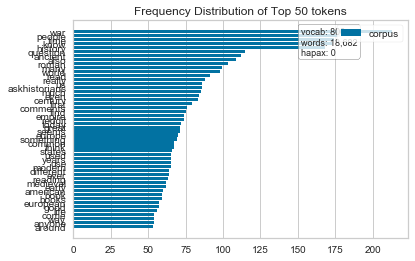

<Figure size 1080x720 with 0 Axes>

In [105]:
mask       = (df['science'] == 0)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
visualizer = FreqDistVisualizer(features=features,n=50,kwargs={'color':'r'})
visualizer.fit(docs)
plt.figure(figsize=(15,10))
visualizer.poof()

In [106]:
def make_wc(mask):
    # use visualizer to create word frequency list for Wordcloud
    # (it is also possible to let wordcloud create the list)
    docs       = cvec.fit_transform(text for text in df['text'][mask])
    features   = cvec.get_feature_names()
    #create dataframe of word frequencies
    word_freq = pd.DataFrame({'word':features,'freq':list(visualizer.count(docs))})
    word_freq = word_freq.sort_values(by = ['freq'],ascending=False)
    # convert df into dict
    w_dict = dict([(word_freq['word'].iloc[i],word_freq['freq'].iloc[i]) for i in range(len(word_freq))])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=1000,height=500,scale=1,background_color="white").generate_from_frequencies(w_dict)
    # Display the generated image:
    plt.rcParams['figure.figsize'] = (20, 10)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.show()
    return fig

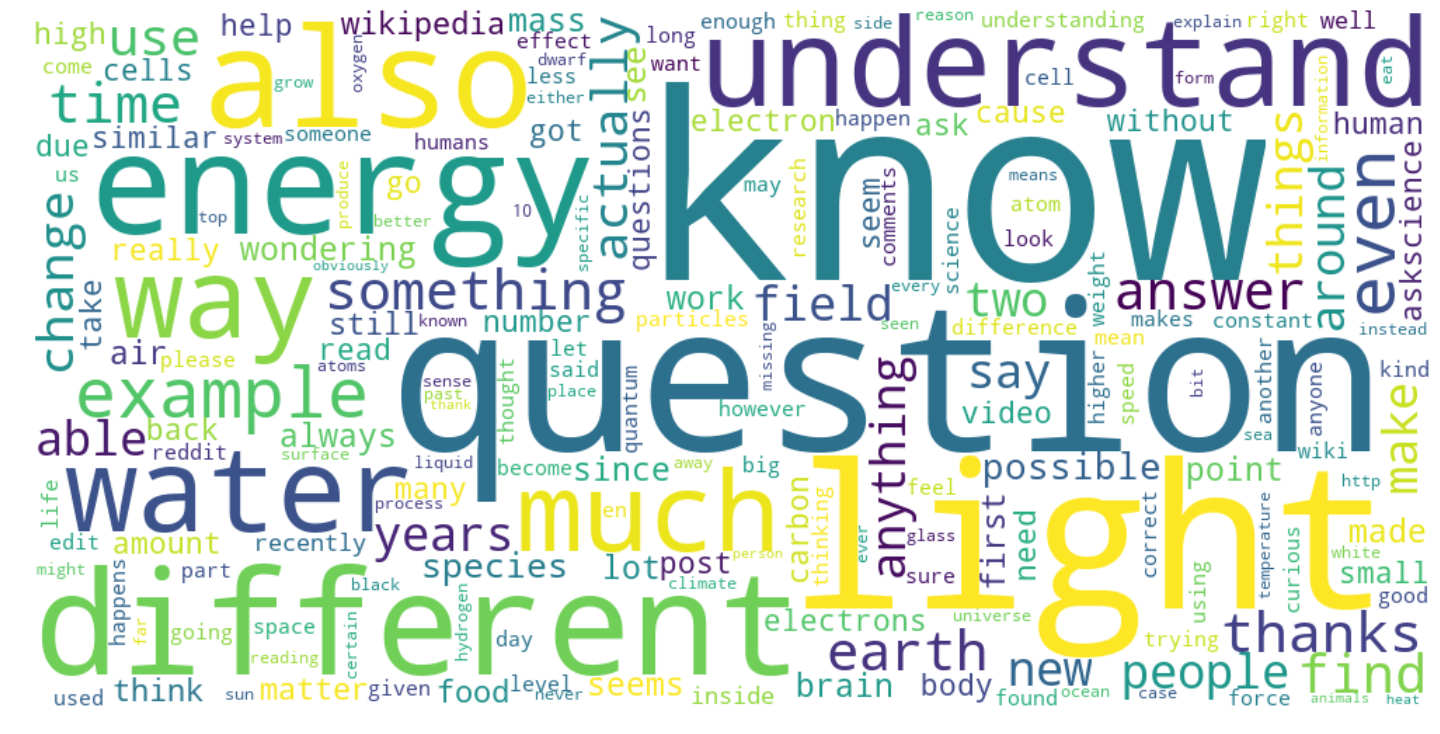

In [105]:
mask = (df['science'] == 1)  # select which subreddit to use
name = 'science'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');

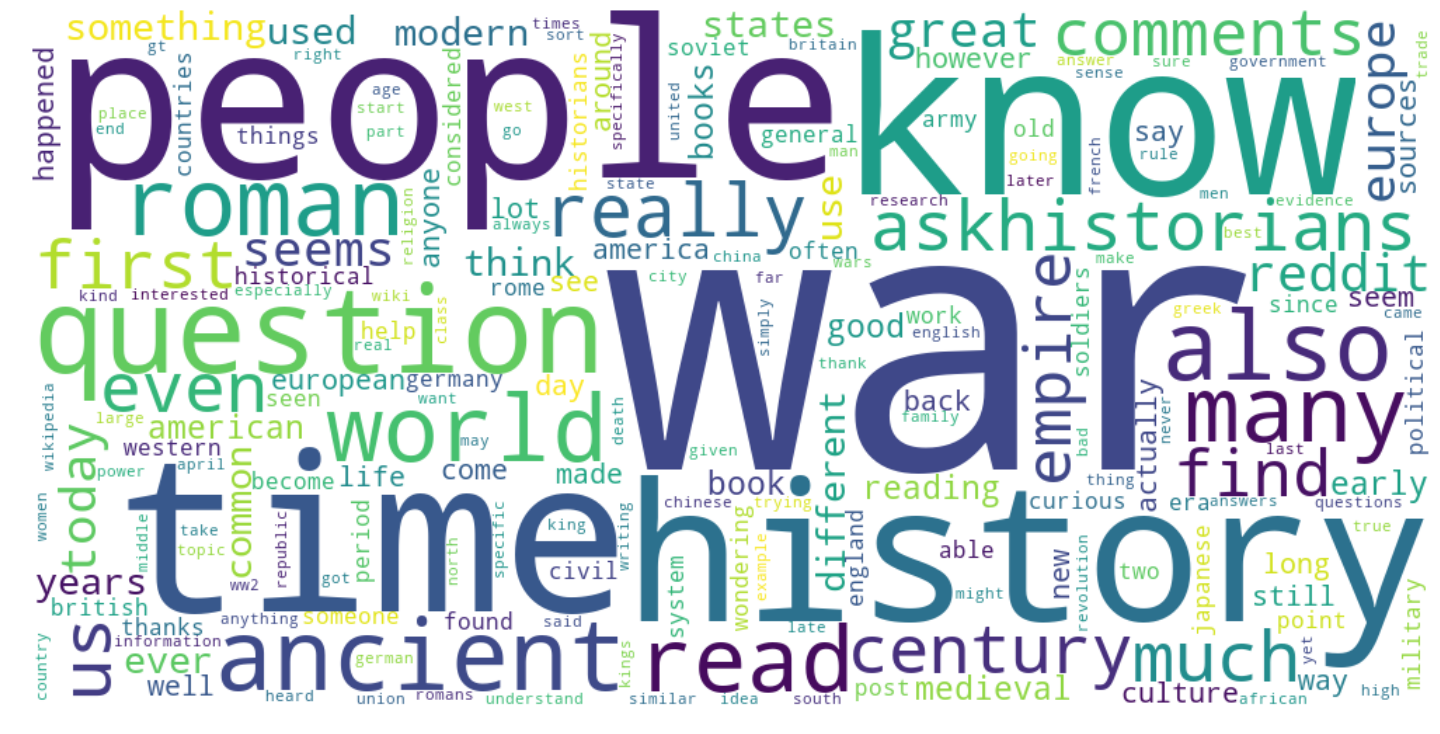

In [107]:
mask = (df['science'] == 0)  # select which subreddit to use
name = 'history'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');